## Reducing Aviation Fatalities: A Neural Network approach using Pytorch

This kernel aims to create a neural network using pytorch. I am new to pytorch and I am still learning the nitty gritties of pytorch so if you find any mistakes or any imporvements that can be done please let me know in the comments section and I will be more than happy to address it.

**I am used a small subset of test set (10000 rows) to generate the predictions as the number of rows in test set is huge and everytime I try to load the test set and do some operations, kernel runs out of memory.  **

### TODO
* Calculate the accuracy of the model. As of now the code is commented out as I am not sure if I am doing it correctly

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
print(os.listdir("../input"))
print(torch.__version__)
%matplotlib inline

In [ ]:
df_train = pd.read_csv("../input/train.csv")
df_train.head()

In [150]:
df_train.shape

(4867421, 28)

In [151]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
crew          int64
experiment    int64
time          float64
seat          int64
eeg_fp1       float64
eeg_f7        float64
eeg_f8        float64
eeg_t4        float64
eeg_t6        float64
eeg_t5        float64
eeg_t3        float64
eeg_fp2       float64
eeg_o1        float64
eeg_p3        float64
eeg_pz        float64
eeg_f3        float64
eeg_fz        float64
eeg_f4        float64
eeg_c4        float64
eeg_p4        float64
eeg_poz       float64
eeg_c3        float64
eeg_cz        float64
eeg_o2        float64
ecg           float64
r             float64
gsr           float64
event         int64
dtypes: float64(24), int64(4)
memory usage: 1.0 GB


In [ ]:
#Use only a small subset of the Test set.
# use the test data set later 
# df_test = pd.read_csv("../input/test.csv", nrows=10000)
# df_test.head()

In [ ]:
# df_test.shape

In [ ]:
# draw the count plot by the group of event 
sns.countplot(x='event', data=df_train)

In [ ]:
print(df_train['experiment'].unique())
# print(df_test['experiment'].unique())

In [ ]:
# mapping the experiment to a certain mark
dic = {'CA': 0, 'DA': 1, 'SS': 2, 'LOFT': 3}
df_train["experiment"] = df_train["experiment"].apply(lambda x: dic[x])
# df_test["experiment"] = df_test["experiment"].apply(lambda x: dic[x])

In [ ]:
# mapping the eveent to a certain mark
dic = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
df_train["event"] = df_train["event"].apply(lambda x: dic[x])

In [ ]:
df_train.head()

In [ ]:
# X is the feature and y is the label data
X = df_train.drop(columns=['event'], axis = 1)
Y = df_train['event']

In [152]:
X.shape

(4867421, 27)

In [ ]:
# Standardize features by removing the mean and scaling to unit variance
# The standard score of a sample x is calculated as:
# z = (x - u) / s
# the unit is from -1 to 1.

# Note: the standardScaler is based on the all the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [ ]:
# make the category into the ont-hot embedding.
def to_categorical(y, num_classes):
    """
    1-hot encodes a tensor
    y is a pandas.Series type data
    """
    return np.eye(num_classes, dtype='uint8')[y]

In [ ]:
# convert the y_train/y_valid into numpy ndarray
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

In [153]:
y_train.shape
# type(y_train)

(3893936, 4)

In [ ]:
# conver it into tensor
featuresTrain = torch.from_numpy(X_train).float()
targetsTrain = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

In [ ]:
# convert the array to tensor
featuresValid = torch.from_numpy(X_valid).float()
targetsValid = torch.from_numpy(y_valid).type(torch.LongTensor) # data type is long

In [ ]:
# X_test = df_test.drop(['id'], axis = 1)
# X_test.shape

In [ ]:
# X_test_scaled = scaler.transform(X_test)

In [ ]:
# featuresTest = torch.from_numpy(X_test_scaled).float()

In [154]:
batch_size = 512
num_epochs = 100
# Pytorch train and test sets
# see the doc of the TensorDataset
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
valid = torch.utils.data.TensorDataset(featuresValid,targetsValid)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid, batch_size = batch_size, shuffle = True)

In [158]:
class NeuralNetwork(nn.Module):
    '''
    Build a fully connected layer 
    '''
    def __init__(self, n_features, n_neurons, dropouts):
        super().__init__()
        self.layer1 = nn.Linear(in_features=n_features, out_features=n_neurons[0])
        self.dropout1 = nn.Dropout(dropouts[0])
        self.layer2 = nn.Linear(in_features=n_neurons[0], out_features=n_neurons[1])
        self.dropout2 = nn.Dropout(dropouts[1])
        self.out_layer = nn.Linear(in_features=n_neurons[1], out_features=4)
     
    def forward(self, X):
        out = F.relu(self.layer1(X))
        out = self.dropout1(out)
        out = F.relu(self.layer2(out))
        out = self.dropout2(out)
        out = self.out_layer(out)
        # it seems that the log_softmax works better than the softmax
        return F.log_softmax(out, dim=1)
        

In [159]:
# Initialize the neural network 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_features = 27
n_neurons = [100, 50]
dropouts = [0.3, 0.2]
model = NeuralNetwork(n_features, n_neurons, dropouts)
model = model.to(device)
# Cross Entropy Loss 
# since we have add the softmax into the forward function in the neural network, we use the NLLLoss function here
error = nn.NLLLoss()
# Adam Optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [166]:
# train_losses = []
# train_acc = []
# valid_losses = []
# valid_acc = []
num_epochs = 5
for e in range(num_epochs):
    start_time = time.time()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for i, (features, labels) in enumerate(train_loader):
        #print(labels)
        # Use the GPU to do the training 
        features, labels = features.to(device), labels.to(device)
        # clean the gradient everytime and do the backward 
        optimizer.zero_grad()
        outputs = model(features)
#         print(outputs)
        loss = error(outputs, torch.max(labels, 1)[1])
        #loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        # update training loss
        train_loss += loss.item()*features.size(0)
        
        #TODO: Calculate the accuracy on the train test
        #acc = torch.eq(outputs.round(), labels).float().mean() # accuracy
        #_, predicted = torch.max(outputs.data, 1)
        #_, actual = torch.max(labels, 1)
        #total = len(labels)
        #correct = (predicted == actual).sum()
        #train_accuracy = 100 * correct / total
        #train_losses.append(train_loss.item())
        #train_acc.append(train_accuracy.item())
        
    model.eval()
    for i, (features, labels) in enumerate(valid_loader):
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = error(outputs, torch.max(labels, 1)[1]) # the max return the maximum value and the index
        #loss = error(outputs, labels)
        valid_loss += loss.item()*features.size(0)
        
        #_, predicted = torch.max(outputs.data, 1)
        #_, actual = torch.max(labels, 1)
        #total = len(labels)
        #correct = (predicted == actual).sum()
        #accuracy = 100 * correct / total
        #valid_losses.append(loss.item())
        #valid_acc.append(accuracy.item())
    
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    elapsed_time = time.time() - start_time
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTime: {:.2f}'.format(
        e+1, train_loss, valid_loss, elapsed_time))    
    
#     if e % 1 == 0:
#         print("[{}/{}], Train Loss: {} Train Acc: {}, Validation Loss : {}, Validation Acc: {} ".format(e+1,
#         num_epochs, np.round(train_loss.item(), 3), np.round(train_accuracy.item(), 3), 
#         np.round(loss.item(), 3), np.round(accuracy.item(), 3)))

Epoch: 1 	Training Loss: 0.188357 	Validation Loss: 0.159395 	Time: 45.00
Epoch: 2 	Training Loss: 0.166708 	Validation Loss: 0.140342 	Time: 46.20
Epoch: 3 	Training Loss: 0.158729 	Validation Loss: 0.138296 	Time: 46.49
Epoch: 4 	Training Loss: 0.153983 	Validation Loss: 0.134204 	Time: 46.02
Epoch: 5 	Training Loss: 0.152082 	Validation Loss: 0.131632 	Time: 45.86


**try to plot the confusion matrix of the prediction**

In [169]:
# #  test the cat function 
# prediction_labels_cm=torch.tensor([1])
# prediction_labels_cm=torch.cat((prediction_labels_cm,torch.tensor([1,2,3,4])),dim=0)
# torch.cat((prediction_labels_cm,torch.tensor([1,2,3,4])),dim=0)

In [170]:
# switch to the evaluation mode
model.eval()
for i, (features, labels) in enumerate(valid_loader):
    features, labels = features.to(device), labels.to(device)
    outputs = model(features)
#     make prediction based on the features of each data
    if i ==0:
        prediction_labels_cm=torch.max(outputs,dim=1)[1]
#         print(i,"\n",prediction_labels_cm)
    else:
        prediction_labels_cm=torch.cat((prediction_labels_cm,torch.max(outputs,dim=1)[1]),dim=0)
#         print(torch.max(outputs,dim=1)[1])
#         print(i,"\n",prediction_labels_cm)
print(prediction_labels_cm.size())
# the size of validation data set is 973485

torch.Size([973485])


In [186]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Oranges):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f' if normalize else 'd'

    fig, ax = plt.subplots()
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)
    

In [172]:
# get the true labels of the validation data set 
valid_labels_cm=torch.max(torch.tensor(y_valid),1)[1]
valid_labels_cm.size()

torch.Size([973485])

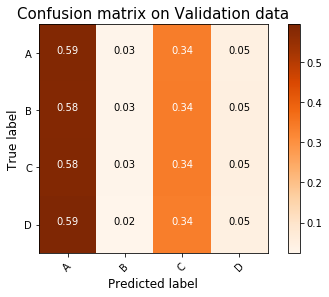

In [187]:
conf_mat_val = confusion_matrix(prediction_labels_cm.cpu(), valid_labels_cm)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

In [ ]:
# test = torch.utils.data.TensorDataset(featuresTest)
# test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
# test_preds = np.zeros((len(test), 4))

# for i, (x_batch,) in enumerate(test_loader):
#     x_batch = x_batch.to(device)
#     y_pred = model(x_batch).detach()
#     test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred.cpu().numpy()

In [ ]:
# test_preds.shape

In [ ]:
# test_preds[100:110, :]

In [ ]:
# submission = pd.DataFrame({'id':df_test['id'],'A':test_preds[:, 0], 'B':test_preds[:, 1],
#                           'C':test_preds[:, 2], 'D':test_preds[:, 3]})
# submission.head()